In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Imports

In [8]:
import os
import sys
import jax
import pandas as pd
import numpy as np
import jax.numpy as jnp
import haiku as hk
import seaborn as sns
import matplotlib.pyplot as plt


if __package__ is None:

    module_path = os.path.abspath(os.path.join('..'))
    sys.path.append(module_path)

    __package__ = os.path.basename(module_path)
    

from src.models.nucleotide_transformer import NucleotideTransformerConfig, build_nucleotide_transformer_fn
from src.models.pretrained import FixedSizeNucleotidesKmersTokenizer
from src.models.tokenizers_numeric import LogTokenizer


root_dir = '..'

In [9]:
data_fn = 'data/processed/ensemble_mutation_effect_analysis/2023_06_05_164913/tabulated_mutation_info.csv'
# data_fn = 'data/raw/ensemble_mutation_effect_analysis/2023_05_16_174613/tabulated_mutation_info.csv'
data_fn = os.path.join(root_dir, data_fn)

data = pd.read_csv(data_fn)

In [10]:
data['sample_seq'] = 'ACGUACGUACGUACGUACGU'

## Model Definition

In [11]:
def calculate_max_positions(max_seq_length, circuit_size, k_for_kmers, kmer_overlap):
    pad = True
    cls = True
    return int(
        circuit_size * (max_seq_length / (k_for_kmers - kmer_overlap) + 2 * pad + 2 * cls)
    )


hyperparams = {
    'k_for_kmers': 5,
    'max_positions': 32,
    'embed_scale': 1.0,
    'emb_layer_norm_before': False,
    'key_size': 64,
    'attention_heads': 20,
    'embed_dim': 140, # 1280,
    'ffn_embed_dim': 512, # 5120,
    'num_layers': 24,
    'token_dropout': True,
    'masking_ratio': 0.15,
    'masking_prob': 0.8,
    'use_gradient_checkpointing': False,
}

max_seq_length = data['sample_seq'].apply(len).max()
kmer_overlap = 0
circuit_size = len(data['sample_name'].unique())

tokenizer = FixedSizeNucleotidesKmersTokenizer(
    k_mers=hyperparams["k_for_kmers"],
    fixed_length=calculate_max_positions(max_seq_length, circuit_size, hyperparams["k_for_kmers"], kmer_overlap),
    prepend_cls_token=True,
    append_eos_token=True,
    nucleotide_type='RNA'
)
tokenizer_n = LogTokenizer(
    granularity=5,
    max_exp=6,
    min_exp=-13,
    prepend_cls_token=True,
    append_eos_token=True,
)

embeddings_layers_to_save = tuple(np.arange(hyperparams["num_layers"]))
attention_maps_to_save = ((1, 4, 5), (7, 18))  # t[0] is the layer index, rest is attention map
encfg = NucleotideTransformerConfig(
    alphabet_size=len(tokenizer.vocabulary) - 2,
    pad_token_id=tokenizer.pad_token_id,
    mask_token_id=tokenizer.mask_token_id,
    max_positions=hyperparams['max_positions'],
    embed_scale=hyperparams["embed_scale"],
    # architecture
    emb_layer_norm_before=hyperparams["emb_layer_norm_before"],
    key_size=hyperparams["key_dim"] if "key_dim" in hyperparams.keys() else None,
    attention_heads=hyperparams["attention_heads"],
    embed_dim=hyperparams["embed_dim"],
    ffn_embed_dim=hyperparams["ffn_embed_dim"],
    num_layers=hyperparams["num_layers"],
    # bert
    token_dropout=hyperparams["token_dropout"],
    masking_ratio=hyperparams["masking_ratio"],
    masking_prob=hyperparams["masking_prob"],
    # embeddings to save
    embeddings_layers_to_save=embeddings_layers_to_save,
    attention_maps_to_save=attention_maps_to_save,
)



In [12]:
batch_size = 100

# sensitivities = data.groupby(['circuit_name', 'mutation_name']).agg({'sensitivity': 'mean'})['sensitivity'].iloc[:batch_size].to_numpy()
sensitivities = data.pivot(index=['circuit_name', 'mutation_name'], columns='sample_name', values='sensitivity').iloc[:batch_size].to_numpy()
tokens_n_ids = [b[1] for b in tokenizer_n.batch_tokenize(sensitivities)]
tokens_n_str = [b[0] for b in tokenizer_n.batch_tokenize(sensitivities)]
tokens_n = jnp.asarray(tokens_ids, dtype=jnp.int32)


NameError: name 'tokens_ids' is not defined

In [ ]:
sensitivities

array([[9.9999994e-01, 3.1720175e-04, 3.1720175e-04],
       [9.9999994e-01, 3.1720175e-04, 3.1720175e-04],
       [9.9999994e-01, 3.1720175e-04, 3.1720175e-04],
       [9.9999994e-01, 3.1720175e-04, 3.1720175e-04],
       [1.0000000e+00, 4.1887286e-04, 4.1887286e-04],
       [9.9999994e-01, 3.1720175e-04, 3.1720175e-04],
       [9.9999994e-01, 3.1720175e-04, 3.1720175e-04],
       [9.9999994e-01, 3.1720175e-04, 3.1720175e-04],
       [9.9999994e-01, 3.1720175e-04, 3.1720175e-04],
       [9.9999994e-01, 3.1720175e-04, 3.1720175e-04],
       [9.9999994e-01, 3.1720175e-04, 3.1720175e-04],
       [1.0000000e+00, 3.5458517e-03, 1.1255274e-01],
       [9.9999994e-01, 3.1720175e-04, 3.1720175e-04],
       [1.0000000e+00, 1.3784019e-02, 1.8880663e-04],
       [1.0000000e+00, 3.1176400e-04, 9.8697010e-04],
       [9.9999994e-01, 3.1720175e-04, 3.1720175e-04],
       [9.9999994e-01, 3.1720175e-04, 3.1720175e-04],
       [9.9999994e-01, 3.1720175e-04, 3.1720175e-04],
       [9.9999994e-01, 9.250

In [ ]:
batch_size = 100

sequences = data.groupby(['circuit_name', 'mutation_name']).agg({'sample_seq': lambda x: [*x]})['sample_seq'].iloc[:batch_size].to_numpy()
tokens_ids = [b[1] for b in tokenizer.batch_tokenize(sequences)]
tokens_str = [b[0] for b in tokenizer.batch_tokenize(sequences)]
tokens = jnp.asarray(tokens_ids, dtype=jnp.int32)


In [ ]:
forward_fn = build_nucleotide_transformer_fn(encfg)
forward_fnt = hk.transform(forward_fn)

rng = hk.PRNGSequence(jax.random.PRNGKey(42))
params = forward_fnt.init(next(rng), tokens[0, None])

In [ ]:
outs = forward_fnt.apply(params, next(rng), tokens[:100])

In [ ]:
outs.keys()

dict_keys(['embeddings_1', 'attention_map_layer_1_number_4', 'attention_map_layer_1_number_5', 'embeddings_2', 'embeddings_3', 'embeddings_4', 'embeddings_5', 'embeddings_6', 'embeddings_7', 'attention_map_layer_7_number_18', 'embeddings_8', 'embeddings_9', 'embeddings_10', 'embeddings_11', 'embeddings_12', 'embeddings_13', 'embeddings_14', 'embeddings_15', 'embeddings_16', 'embeddings_17', 'embeddings_18', 'embeddings_19', 'embeddings_20', 'embeddings_21', 'embeddings_22', 'embeddings_23', 'logits'])

In [ ]:
outs['logits'].shape

(100, 24, 1033)

## Outs

### Numerical

In [ ]:
embeddings = outs["embeddings_20"][:, 1:, :]  # removing CLS token
padding_mask = jnp.expand_dims(tokens_n[:batch_size, 1:] != tokenizer_n.pad_token_id, axis=-1)
masked_embeddings = embeddings * padding_mask  # multiply by 0 pad tokens_n embeddings
sequences_lengths = jnp.sum(padding_mask, axis=1)
mean_embeddings = jnp.sum(masked_embeddings, axis=1) / sequences_lengths

logits = outs["logits"]
probabilities = []

# get probabilities separately for each seq as they have different lengths
for seq_id in range(logits.shape[0]):

    logits_seq = logits[seq_id]
    seq_length = int(sequences_lengths[seq_id])
    logits_seq = logits_seq[1 : (seq_length + 1)]  # remove CLS token and pads
    probas = jax.nn.softmax(
        logits_seq, axis=-1
    )  # use softmax to transform logits into probabilities

    probabilities.append(probas)

TypeError: mul got incompatible shapes for broadcasting: (100, 23, 140), (100, 5, 1).

In [ ]:
sensitivity_id = 0
position_id = 1

probs = probabilities[sensitivity_id][position_id]
sorted_positions = jnp.argsort(-probs)
sorted_probs = probs[sorted_positions]

top_k = 10
for k in range(top_k):
    predicted_token = tokenizer_n.id_to_token(int(sorted_positions[k]))
    prob = sorted_probs[k]
    print(f"token: {predicted_token},\ttoken_id: {int(sorted_positions[k])},\t probability: {prob * 100:.2f}%")

token: 0.8,	token_id: 56,	 probability: 5.85%
token: 60.0,	token_id: 63,	 probability: 5.66%
token: 2e-07,	token_id: 29,	 probability: 3.98%
token: 80.0,	token_id: 64,	 probability: 3.68%
token: 4e-13,	token_id: 6,	 probability: 3.49%
token: 8e-09,	token_id: 24,	 probability: 3.42%
token: 0.4,	token_id: 54,	 probability: 3.22%
token: 4e-09,	token_id: 22,	 probability: 2.70%
token: 20.0,	token_id: 61,	 probability: 2.50%
token: 400000.0,	token_id: 78,	 probability: 2.38%


### Sequences

In [ ]:
embeddings = outs["embeddings_20"][:, 1:, :]  # removing CLS token
padding_mask = jnp.expand_dims(tokens[:batch_size, 1:] != tokenizer.pad_token_id, axis=-1)
masked_embeddings = embeddings * padding_mask  # multiply by 0 pad tokens embeddings
sequences_lengths = jnp.sum(padding_mask, axis=1)
mean_embeddings = jnp.sum(masked_embeddings, axis=1) / sequences_lengths

logits = outs["logits"]
probabilities = []

# get probabilities separately for each seq as they have different lengths
for seq_id in range(logits.shape[0]):

    logits_seq = logits[seq_id]
    seq_length = int(sequences_lengths[seq_id])
    logits_seq = logits_seq[1 : (seq_length + 1)]  # remove CLS token and pads
    probas = jax.nn.softmax(
        logits_seq, axis=-1
    )  # use softmax to transform logits into probabilities

    probabilities.append(probas)

In [ ]:
sensitivity_id = 0
position_id = 1

probs = probabilities[sensitivity_id][position_id]
sorted_positions = jnp.argsort(-probs)
sorted_probs = probs[sorted_positions]

top_k = 10
for k in range(top_k):
    predicted_token = tokenizer.id_to_token(int(sorted_positions[k]))
    prob = sorted_probs[k]
    print(f"token: {predicted_token}, probability: {prob * 100:.2f}%")

token: UAUAA, probability: 1.37%
token: AUAUA, probability: 1.20%
token: CCCAA, probability: 0.99%
token: ACAUU, probability: 0.77%
token: AAGGA, probability: 0.75%
token: CUAGU, probability: 0.73%
token: CUCGA, probability: 0.66%
token: AGAAC, probability: 0.65%
token: UUCUG, probability: 0.60%
token: UAAAA, probability: 0.60%


In [ ]:
outs.keys()

dict_keys(['embeddings_1', 'attention_map_layer_1_number_4', 'attention_map_layer_1_number_5', 'embeddings_2', 'embeddings_3', 'embeddings_4', 'embeddings_5', 'embeddings_6', 'embeddings_7', 'attention_map_layer_7_number_18', 'embeddings_8', 'embeddings_9', 'embeddings_10', 'embeddings_11', 'embeddings_12', 'embeddings_13', 'embeddings_14', 'embeddings_15', 'embeddings_16', 'embeddings_17', 'embeddings_18', 'embeddings_19', 'embeddings_20', 'embeddings_21', 'embeddings_22', 'embeddings_23', 'logits'])

In [ ]:
outs['embeddings_1'].shape

(100, 24, 1280)

<Axes: ylabel='Count'>

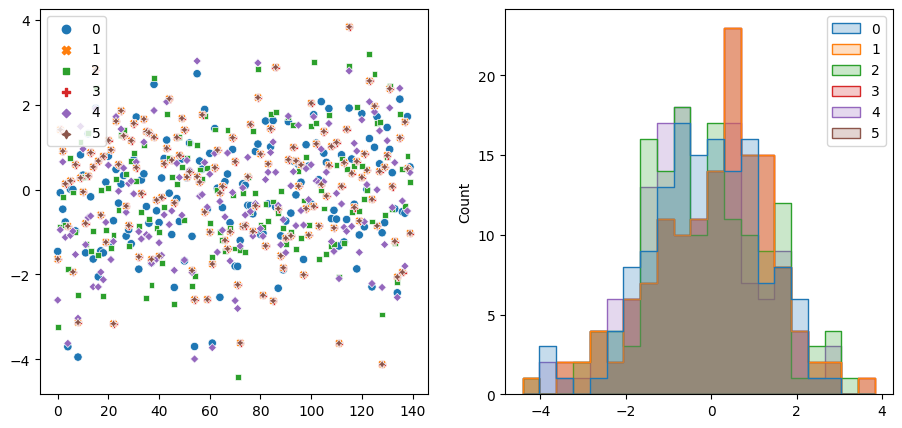

In [ ]:
plt.figure(figsize=(11, 5))
ax = plt.subplot(1,2,1)
sns.scatterplot(jnp.average(outs_d['embeddings_1'], axis=0).T)
ax = plt.subplot(1,2,2)
sns.histplot(jnp.average(outs_d['embeddings_1'], axis=0).T, element='step')


# Train

Adapted from https://github.com/deepmind/dm-haiku/blob/main/examples/transformer/train.py

In [ ]:

from pytorch_metric_learning.losses import SelfSupervisedLoss, NTXentLoss

import torch
from tqdm import tqdm
import optax

from typing import Any, MutableMapping, NamedTuple, Tuple, Union

In [ ]:

LEARNING_RATE = 3e-4
GRAD_CLIP_VALUE = 1

Funcs

In [ ]:

def optimiser() -> optax.GradientTransformation:
    return optax.chain(
        optax.clip_by_global_norm(GRAD_CLIP_VALUE),
        optax.adam(LEARNING_RATE, b1=0.9, b2=0.99),
    )
    

Init training

In [ ]:

class TrainingState(NamedTuple):
    """Container for the training state."""
    params: hk.Params  # Current network parameters.
    opt_state: optax.OptState  # Optimiser state (e.g. gradient moments).
    rng_key: jax.Array  # RNG used for e.g. dropout. Split on each update step.
    step: jax.Array  # Tracks the number of training steps.


@jax.jit
def init_train(rng: jax.Array, tokens) -> TrainingState:
    """Makes an initial training state (random parameters)."""
    # rng, init_rng = jax.random.split(rng)
    initial_params = forward_fnt.init(next(rng), tokens[0, None])
    initial_opt_state = optimiser().init(initial_params)
    return TrainingState(
        params=initial_params,
        opt_state=initial_opt_state,
        rng_key=rng,
        step=jnp.array(0),
    )



In [ ]:
# @hk.transform
def loss_fn(logits, pad_token_id) -> jax.Array:
    """Computes the (scalar) language modelling loss on `data` w.r.t. params."""
    log_probs = jax.nn.log_softmax(logits)  # [B, T, V]
    # SelfSupervisedLoss(NTXentLoss())
    onehot_targets = jax.nn.one_hot(data.targets, logits.shape[-1]) #dataset.VOCAB_SIZE)
    log_likelihood = jnp.sum(onehot_targets * log_probs, axis=-1)  # [B, T]

    # Loss is the average negative log-likelihood per (non-masked) token.
    mask = jnp.not_equal(data.inputs, pad_token_id)  # [B, T]
    return -jnp.sum(log_likelihood * mask) / jnp.sum(mask)  # []


In [ ]:


@jax.jit
def update(
        state: TrainingState, data) -> Tuple[TrainingState, dict]:
    """Does an SGD step, returning a new training state and metrics."""
    rng, net_rng = jax.random.split(state.rng_key)
    loss_and_grad_fn = jax.value_and_grad(loss_fn.apply)
    loss, gradients = loss_and_grad_fn(state.params, net_rng, data)

    updates, new_opt_state = optimiser().update(gradients, state.opt_state)
    new_params = optax.apply_updates(state.params, updates)

    new_state = TrainingState(
        params=new_params,
        opt_state=new_opt_state,
        rng_key=rng,
        step=state.step + 1,
    )

    metrics = {
        'step': state.step,
        'loss': loss,
    }
    return new_state, metrics

In [ ]:
num_epochs = 1000

rng = hk.PRNGSequence(jax.random.PRNGKey(42))
loss_func = SelfSupervisedLoss(NTXentLoss())
losses = []

# Get the total number of mini-batches per epoch based on the smallest data loader
num_batches = 10  # min(len(go_train_dataloader), len(text_train_dataloader), len(dna_train_dataloader), len(aa_train_dataloader))

batch_size = int(len(sequences) / num_batches)
tokens_ids = [b[1] for b in tokenizer.batch_tokenize(sequences[:2])]
tokens = jnp.asarray(tokens_ids, dtype=jnp.int32)

# state = init_train(rng, tokens)
initial_params = forward_fnt.init(next(rng), tokens[0, None])
initial_opt_state = optimiser().init(initial_params)
state = TrainingState(
    params=initial_params,
    opt_state=initial_opt_state,
    rng_key=rng,
    step=jnp.array(0),
)
metrics_all = {
    'step': [],
    'loss': [],
}

for epoch in tqdm(range(num_epochs)):
    for batch_idx in range(num_batches):
        seq_batch = sequences[batch_idx:np.min([batch_idx+batch_size, len(sequences)])]
    # for batch_idx, (seq_batch, sens_batch) in enumerate(zip(sequences, sensitivities)):
        print(seq_batch)
        
        # Tokens
        tokens_ids = [b[1] for b in tokenizer.batch_tokenize(seq_batch)]
        tokens = jnp.asarray(tokens_ids, dtype=jnp.int32)
        # tokens_ids = [b[1] for b in tokenizer_n.batch_tokenize(sens_batch)]
        # tokens_n = jnp.asarray(tokens_ids, dtype=jnp.int32)

        # Apply
        outs = forward_fnt.apply(params, next(rng), tokens[:100])
        # outs_d = forward_fnt_d.apply(params_d, next(rng), tokens_n[:100])
        
        logits = outs["logits"]
        # logits_d = outs_d["logits"]


        loss_and_grad_fn = jax.value_and_grad(loss_fn)
        loss, gradients = loss_and_grad_fn(params, next(rng), logits, tokenizer.pad_token_id)
        losses.append(loss)

        # params = jax.tree_util.tree_map(update_rule, params, grads)
        updates, new_opt_state = optimiser().update(gradients, state.opt_state)
        new_params = optax.apply_updates(state.params, updates)

        metrics_all['step'].append(state.step)
        metrics_all['loss'].append(loss)


    # if epoch != 0 and (epoch + 1) % 1 == 0:
    #     print(f"Epoch {epoch+1}: joint loss {sum(losses) / num_batches}")
    #     losses = []

  0%|          | 0/1000 [00:00<?, ?it/s]

[list(['ACGUACGUACGUACGUACGU', 'ACGUACGUACGUACGUACGU', 'ACGUACGUACGUACGUACGU'])
 list(['ACGUACGUACGUACGUACGU', 'ACGUACGUACGUACGUACGU', 'ACGUACGUACGUACGUACGU'])
 list(['ACGUACGUACGUACGUACGU', 'ACGUACGUACGUACGUACGU', 'ACGUACGUACGUACGUACGU'])
 list(['ACGUACGUACGUACGUACGU', 'ACGUACGUACGUACGUACGU', 'ACGUACGUACGUACGUACGU'])
 list(['ACGUACGUACGUACGUACGU', 'ACGUACGUACGUACGUACGU', 'ACGUACGUACGUACGUACGU'])
 list(['ACGUACGUACGUACGUACGU', 'ACGUACGUACGUACGUACGU', 'ACGUACGUACGUACGUACGU'])
 list(['ACGUACGUACGUACGUACGU', 'ACGUACGUACGUACGUACGU', 'ACGUACGUACGUACGUACGU'])
 list(['ACGUACGUACGUACGUACGU', 'ACGUACGUACGUACGUACGU', 'ACGUACGUACGUACGUACGU'])
 list(['ACGUACGUACGUACGUACGU', 'ACGUACGUACGUACGUACGU', 'ACGUACGUACGUACGUACGU'])
 list(['ACGUACGUACGUACGUACGU', 'ACGUACGUACGUACGUACGU', 'ACGUACGUACGUACGUACGU'])]


  0%|          | 0/1000 [00:00<?, ?it/s]


TypeError: loss_fn() takes 2 positional arguments but 4 were given